In [5]:
!pip install xlrd

     ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
     ---------------------------------------- 96.5/96.5 kB 5.8 MB/s eta 0:00:00


In [1]:
!curl -L https://forecasters.org/data/m3comp/M3C.xls -o m3_dataset.xls
!curl -L https://data.transportation.gov/api/views/xgub-n9bw/rows.csv -o carrier_passengers.csv
!curl -L https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Train/Monthly-train.csv -o m4_monthly.csv
!curl -L https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/M4-info.csv -o m4_metadata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 11 1716k   11  201k    0     0   400k      0  0:00:04 --:--:--  0:00:04  401k
100 1716k  100 1716k    0     0  2405k      0 --:--:-- --:--:-- --:--:-- 2410k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  207k    0  207k    0     0   116k      0 --:--:--  0:00:01 --:--:--  116k
100 2526k    0 2526k    0     0   901k      0 --:--:--  0:00:02 --:--:--  901k
100 3966k    0 3966k    0     0  1036k      0 --:--:--  0:00:03 --:--:-- 1037k
100 5262k    0 5262k    0     0  1101k      0 --:-

In [71]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict, Optional
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mae
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import *
from darts.models import LightGBMModel

In [3]:
#We pick 18 months for forecast as this is what is used in the M3/M4 competitions for monthly series.
HORIZON = 18

In [9]:
def load_m3() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    print("building M3 TimeSeries...")

    # Read DataFrame
    df_m3 = pd.read_excel("m3_dataset.xls", "M3Month")

    # Build TimeSeries
    m3_series = []
    for row in tqdm(df_m3.iterrows()):
        s = row[1]
        start_year = int(s["Starting Year"])
        start_month = int(s["Starting Month"])
        values_series = s[6:].dropna()
        if start_month == 0:
            continue

        start_date = datetime(year=start_year, month=start_month, day=1)
        time_axis = pd.date_range(start_date, periods=len(values_series), freq="M")
        series = TimeSeries.from_times_and_values(
            time_axis, values_series.values
        ).astype(np.float32)
        m3_series.append(series)

    print("\nThere are {} monthly series in the M3 dataset".format(len(m3_series)))

    # Split train/test
    print("splitting train/test...")
    m3_train = [s[:-HORIZON] for s in m3_series]
    m3_test = [s[-HORIZON:] for s in m3_series]

    # Scale so that the largest value is 1
    print("scaling...")
    scaler_m3 = Scaler(scaler=MaxAbsScaler())
    m3_train_scaled: List[TimeSeries] = scaler_m3.fit_transform(m3_train)
    m3_test_scaled: List[TimeSeries] = scaler_m3.transform(m3_test)

    print(
        "done. There are {} series, with average training length {}".format(
            len(m3_train_scaled), np.mean([len(s) for s in m3_train_scaled])
        )
    )
    return m3_train_scaled, m3_test_scaled

In [10]:
def load_air() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    # download csv file
    df = pd.read_csv("carrier_passengers.csv")
    # extract relevant columns
    df = df[["data_dte", "carrier", "Total"]]
    # aggregate per carrier and date
    df = pd.DataFrame(df.groupby(["carrier", "data_dte"]).sum())
    # move indexes to columns
    df = df.reset_index()

    # group bt carrier, specificy time index and target variable
    all_air_series = TimeSeries.from_group_dataframe(
        df, group_cols="carrier", time_col="data_dte", value_cols="Total", freq="MS"
    )

    # Split train/test
    print("splitting train/test...")
    air_train = []
    air_test = []
    for series in all_air_series:
        # remove the end of the series
        series = series[: pd.Timestamp("2019-12-31")]
        # convert to proper type
        series = series.astype(np.float32)
        # extract longest contiguous slice
        try:
            series = series.longest_contiguous_slice()
        except:
            continue
        # remove static covariates
        series = series.with_static_covariates(None)
        # remove short series
        if len(series) >= 36 + HORIZON:
            air_train.append(series[:-HORIZON])
            air_test.append(series[-HORIZON:])

    # Scale so that the largest value is 1
    print("scaling series...")
    scaler_air = Scaler(scaler=MaxAbsScaler())
    air_train_scaled: List[TimeSeries] = scaler_air.fit_transform(air_train)
    air_test_scaled: List[TimeSeries] = scaler_air.transform(air_test)

    print(
        "done. There are {} series, with average training length {}".format(
            len(air_train_scaled), np.mean([len(s) for s in air_train_scaled])
        )
    )
    return air_train_scaled, air_test_scaled

In [11]:
#a handy function to tell us how good a bunch of forecasted series are

def eval_forecasts(
    pred_series: List[TimeSeries], test_series: List[TimeSeries]
) -> List[float]:

    print("computing sMAPEs...")
    smapes = smape(test_series, pred_series)
    plt.figure()
    plt.hist(smapes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("sMAPE")
    plt.title("Median sMAPE: %.3f" % np.median(smapes))
    plt.show()
    plt.close()
    return smapes

**Global models on the air dataset**

In [12]:
air_train, air_test = load_air()

splitting train/test...


IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.
IndexError: The type of your index was not matched.


scaling series...
done. There are 245 series, with average training length 154.06938775510204


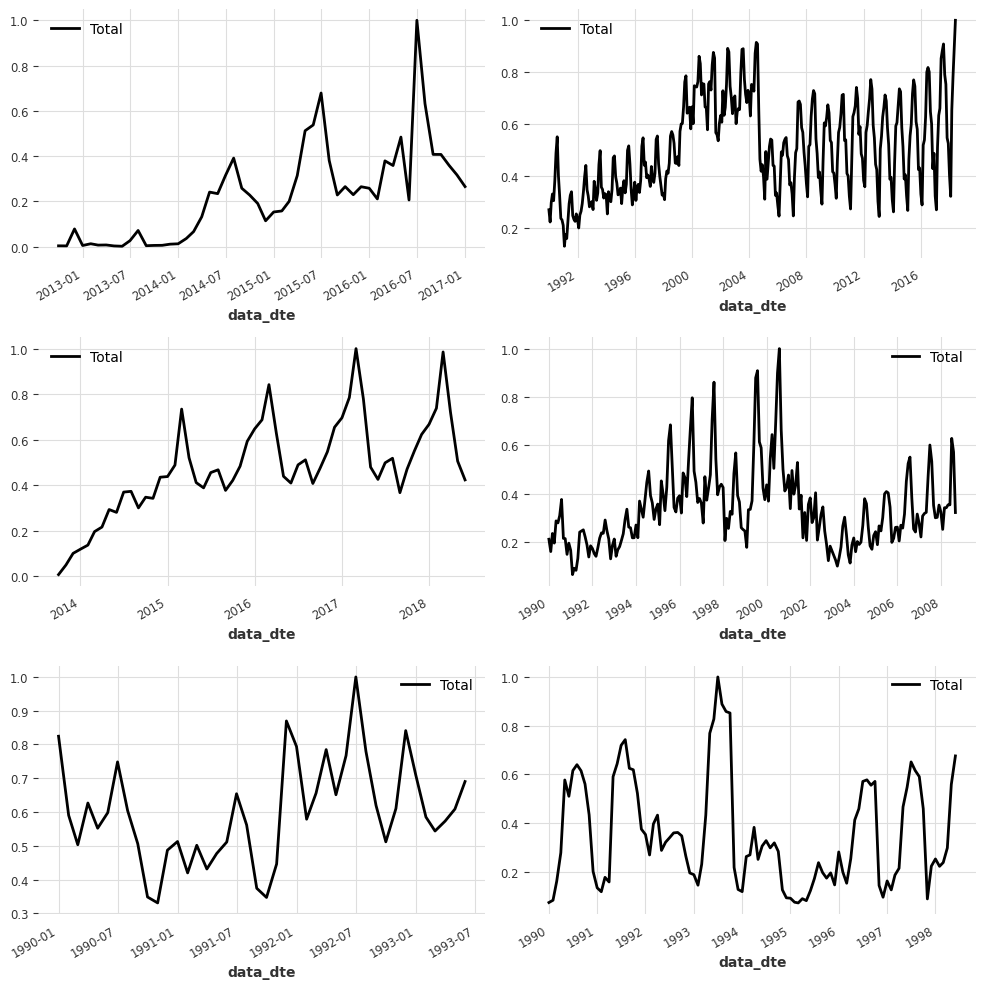

In [17]:
#lets plot some series

figure, ax = plt.subplots(3, 2, figsize=(10, 10))

for i, idx in enumerate([1, 40, 70, 100, 180, 240]):
    axis = ax[i % 3, i % 2]
    air_train[idx].plot(ax=axis)
    axis.legend(air_train[idx].components)
plt.tight_layout()

We can see that most series look quite different, and they even have different time axes! 

In [18]:
def eval_global_model(
    train_series: List[TimeSeries], test_series: List[TimeSeries], model_cls, **kwargs
) -> Tuple[List[float], float]:

    start_time = time.time()

    model = model_cls(**kwargs)
    model.fit(train_series)
    preds = model.predict(n=HORIZON, series=train_series)

    elapsed_time = time.time() - start_time

    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

**Training a Linear regression model on m3 dataset and use it to forecast air dataset**

In [21]:
m3_train, m3_test = load_m3()

building M3 TimeSeries...


0it [00:00, ?it/s]


There are 1399 monthly series in the M3 dataset
splitting train/test...
scaling...
done. There are 1399 series, with average training length 100.30092923516797


In [44]:
lr = LinearRegressionModel(lags=30, output_chunk_length=1)

In [45]:
lr.fit(m3_train)

LinearRegressionModel(lags=30, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

computing sMAPEs...


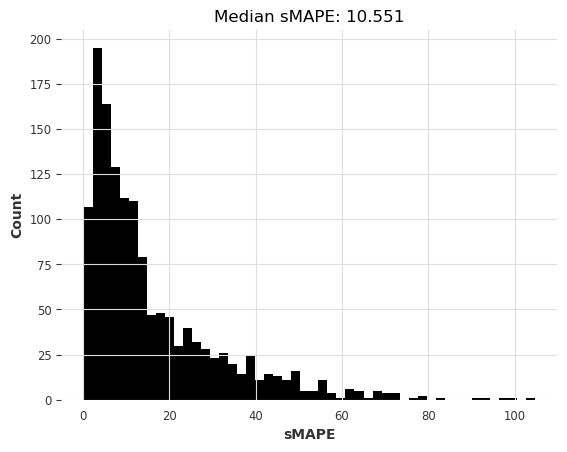

In [46]:
#prediction on m3_train series only

preds = lr.predict(series=m3_train, n=HORIZON)  # get forecasts

lr_smapes = eval_forecasts(preds, m3_test)

computing sMAPEs...


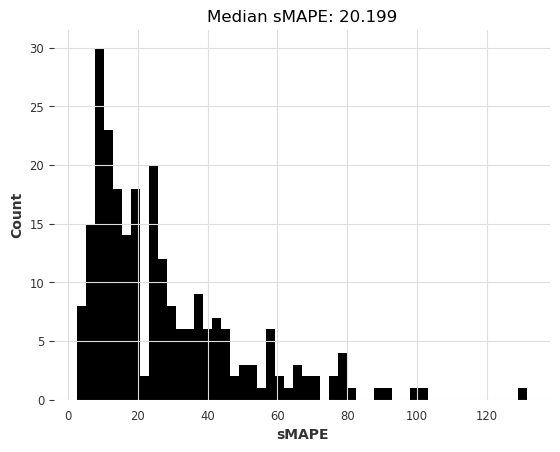

In [43]:
#prediction on air_train series which the lr model has not seen

preds = lr.predict(series=air_train, n=HORIZON)  # get forecasts

lr_smapes = eval_forecasts(preds, air_test)

**Inspecting some predections**

<Axes: xlabel='data_dte'>

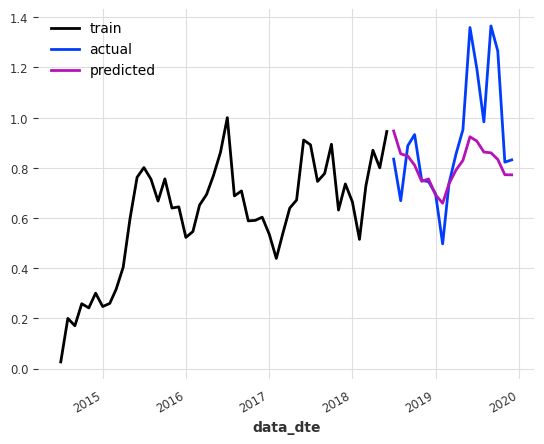

In [40]:
index = 44

air_train[index].plot(label='train')
air_test[index].plot(label='actual')
preds[index].plot(label='predicted')

**we can also inspect manually how this model does on another series – for example, the monthly milk production series available in darts.datasets:**

In [62]:
HORIZON = 48

<Axes: xlabel='Month'>

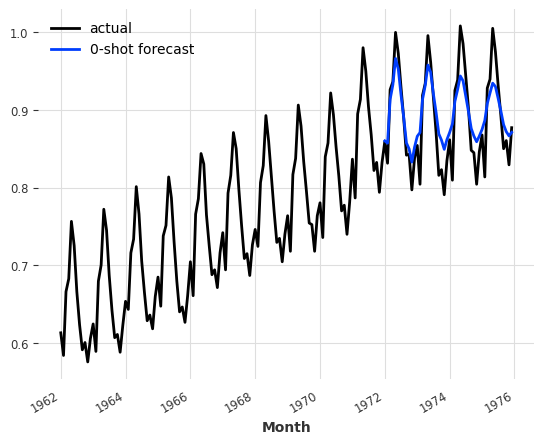

In [63]:
from darts.datasets import MonthlyMilkDataset

series_milk = MonthlyMilkDataset().load().astype(np.float32)
train, val = series[:-HORIZON], series[-HORIZON:]

scaler = Scaler(scaler=MaxAbsScaler())
train_milk = scaler.fit_transform(train)
val_milk = scaler.transform(val)
series_milk = scaler.transform(series_milk)
pred = lr.predict(series=train_milk, n=HORIZON)

series.plot(label="actual")
pred.plot(label="0-shot forecast")

**Lets try comparing the different Global models trained on M3 dataset and predict on MonthlyMilkDataset**

In [91]:
def eval_plot(model):   
    tic = time.time()
    preds = model.predict(n=HORIZON, series=train_milk)
    infer_time = time.time() - tic

    error = smape(val_milk, preds)
    series.plot(label='actual')
    preds.plot(label='predicted')
    print("Mean absolute error: ", error)
    return infer_time, error

Mean absolute error:  3.163497895002365


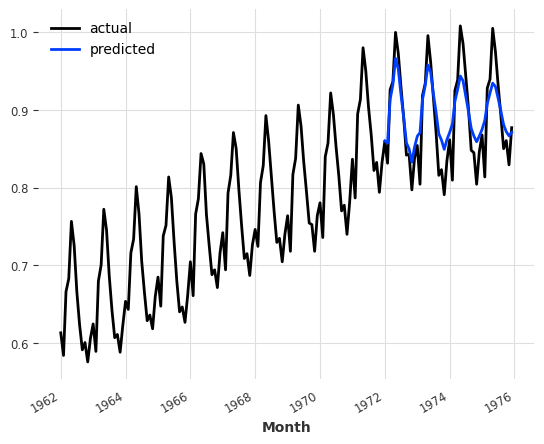

In [92]:
lr_model_m3 = LinearRegressionModel(lags=30, output_chunk_length=1)
lr_model_m3.fit(m3_train)

lr_infer_time, lr_smape = eval_plot(lr_model_m3)

In [78]:
#block RNN model

RNN_model_m3 = BlockRNNModel(input_chunk_length=30, output_chunk_length=1)
RNN_model_m3.fit(m3_train, epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=30, output_chunk_length=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Mean absolute error:  5.349719524383545


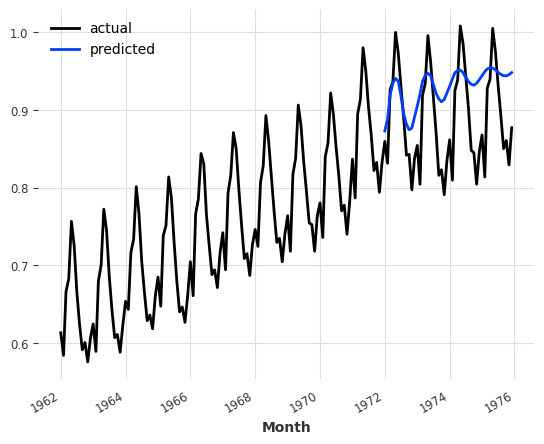

In [94]:
block_rnn_infer_time, block_rnn_smape = eval_plot(RNN_model_m3)

In [84]:
#simple vanilla RNN

simple_RNN_model_m3 = RNNModel(input_chunk_length=30, output_chunk_length=1, model='RNN')
simple_RNN_model_m3.fit(m3_train, epochs=5)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


RNNModel(model=RNN, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=30, output_chunk_length=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Mean absolute error:  5.924643948674202


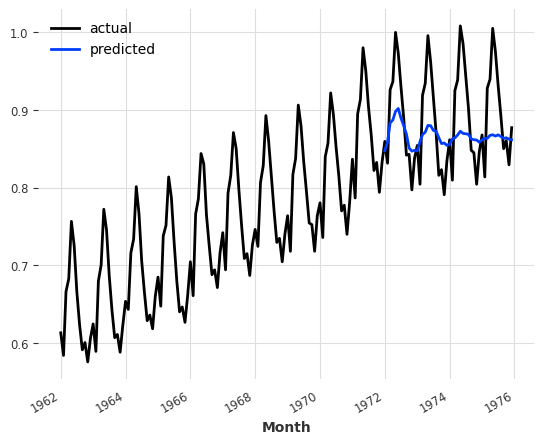

In [97]:
simple_RNN_infer_time, simple_RNN_smape = eval_plot(simple_RNN_model_m3)

In [96]:
#LSTM model

LSTM_model_m3 = RNNModel(input_chunk_length=30, output_chunk_length=1, model='LSTM')
LSTM_model_m3.fit(m3_train, epochs=5)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=30, output_chunk_length=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Mean absolute error:  7.688330113887787


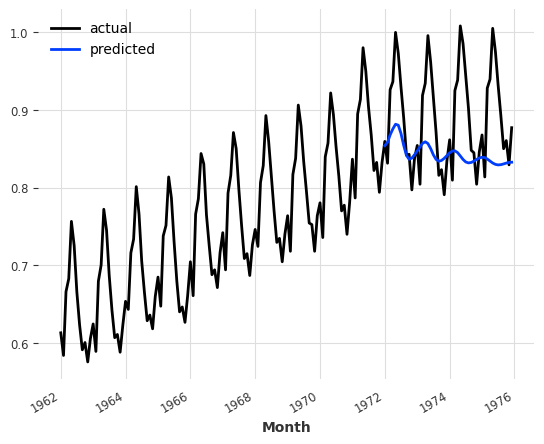

In [98]:
LSTM_infer_time, LSTM_smape = eval_plot(LSTM_model_m3)

In [99]:
#GRU model

GRU_model_m3 = RNNModel(input_chunk_length=30, output_chunk_length=1, model='GRU')
GRU_model_m3.fit(m3_train, epochs=5)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 2.1 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


RNNModel(model=GRU, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=30, output_chunk_length=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Mean absolute error:  7.958289235830307


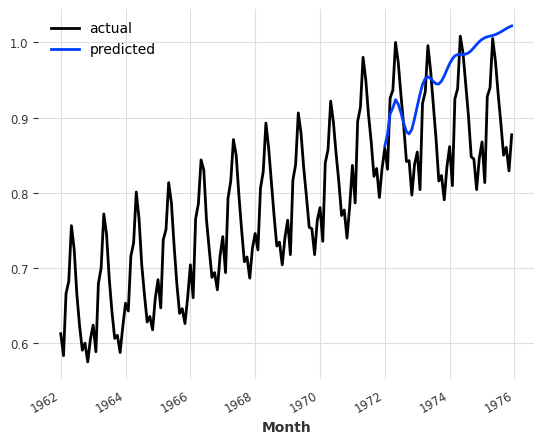

In [100]:
GRU_infer_time, GRU_smape = eval_plot(GRU_model_m3)

In [101]:
#N-Hits model

NHits_model_m3 = NHiTSModel(input_chunk_length=30, output_chunk_length=1)
NHits_model_m3.fit(m3_train, epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 858 K 
---------------------------------------------------
843 K     Trainable params
15.4 K    Non-trainable params
858 K     Total params
3.435     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


NHiTSModel(num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=30, output_chunk_length=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Mean absolute error:  5.9716347604990005


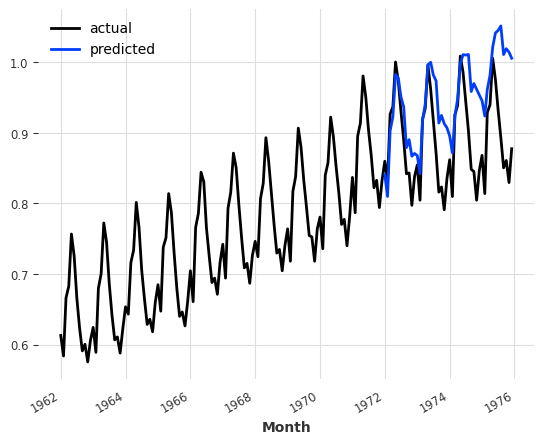

In [103]:
NHits_infer_time, NHits_smape = eval_plot(NHits_model_m3)

**Lets plot and conclude the observations**

In [113]:
def plot_models(elapsed_times, smapes):
    models = list(elapsed_times.keys())

    # Scatter plot with colors for each model
    plt.figure(figsize=(7, 4))
    plt.scatter(elapsed_times.values(), smapes.values(), c=range(len(models)), cmap='tab10', s=100, alpha=0.8)

    for i, model in enumerate(models):
        plt.annotate(model, (list(elapsed_times.values())[i], list(smapes.values())[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='black')

    plt.xlabel('Elapsed Time (s)')
    plt.ylabel('SMAPE')
    plt.title('Model Comparison')
    plt.show()

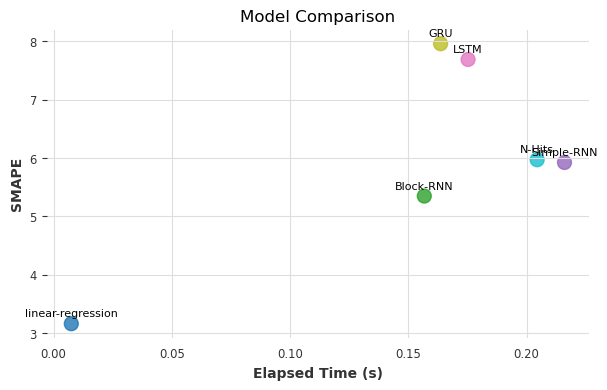

In [114]:
smapes = {
    "linear-regression": lr_smape,
    "Block-RNN": block_rnn_smape,
    "Simple-RNN": simple_RNN_smape,
    "LSTM": LSTM_smape,
    "GRU": GRU_smape,
    "N-Hits": NHits_smape
}

elapsed_times = {
    "linear-regression": lr_infer_time,
    "Block-RNN": block_rnn_infer_time,
    "Simple-RNN": simple_RNN_infer_time,
    "LSTM": LSTM_infer_time,
    "GRU": GRU_infer_time,
    "N-Hits": NHits_infer_time
}

plot_models(elapsed_times, smapes)

**Linear regression seems to work well in tranfer learning from M3 to the prediction Milk dataset
in terms of accuracy and time taken for inference**

**Block-RNN provides good tradeoff but with fine tuning other parameters we can attain good accuracy with Neural network architectures. We have used very minimal parameters**